In [360]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from odps import ODPS
from odps import options
import oss2
from odps.df import DataFrame
import datetime
import pandas as pd
import numpy as np
import threading
import queue
import time

# connect信息
from ACCESS import ACCESS_ID
from ACCESS import SECRET_ACCESS_KEY
from ACCESS import ODPS_PROJECT
from ACCESS import ODPS_ENDPOINT

# # 此为外网地址
OSS_ENDPOINT = 'http://oss-cn-shanghai.aliyuncs.com'
OSS_BUCKET = 'hypertrons'

# oss实例
auth = oss2.Auth(ACCESS_ID, SECRET_ACCESS_KEY)
bucket = oss2.Bucket(auth, OSS_ENDPOINT, OSS_BUCKET)

# 创建odps实例
o = ODPS(ACCESS_ID, SECRET_ACCESS_KEY, project=ODPS_PROJECT, endpoint=ODPS_ENDPOINT)
options.tunnel.limit_instance_tunnel = False
# options.read_timeout = 3600000

hints = {'odps.sql.allow.fullscan': 'true', 'odps.sql.submit.mode': 'script'}
dim_github_repo = DataFrame(o.get_table('dim_github_repo'))
dim_github_repo.dtypes

odps.Schema {
  repo_id                                   int64           
  repo_name                                 string          
  org_id                                    int64           
  org_login                                 string          
  repo_description                          string          
  repo_size                                 int32           
  repo_stargazers_count                     int32           
  repo_forks_count                          int32           
  repo_language                             string          
  repo_has_issues                           int8            
  repo_has_projects                         int8            
  repo_has_downloads                        int8            
  repo_has_wiki                             int8            
  repo_has_pages                            int8            
  repo_license                              string          
  repo_default_branch                       string          
  repo_cre

In [361]:
# 数据清洗
drop_sql = '''
DROP TABLE IF EXISTS repo_info;
CREATE TABLE IF NOT EXISTS repo_info
(
    repo_id STRING,
    repo_name STRING,
    org_id STRING,
    org_login STRING,
    repo_language STRING,
    repo_description STRING,
    repo_stargazers_count STRING
);
'''
o.execute_sql(drop_sql, hints=hints)

select_sql = '''
    INSERT INTO repo_info
    SELECT repo_id, repo_name, org_id, org_login, repo_language, repo_description, repo_stargazers_count
    FROM dim_github_repo
    WHERE org_id IS NOT NULL AND org_id!=0
        AND repo_language IS NOT NULL AND repo_language!='' 
        AND repo_description IS NOT NULL AND repo_description!=''
        AND repo_stargazers_count >= 1000
    '''
o.execute_sql(select_sql, hints=hints)
tmp = DataFrame(o.get_table('repo_info'))
tmp.count()

13890

In [362]:
select_sql = '''
    set odps.sql.validate.orderby.limit=false;
    SELECT repo_name, org_id, org_login, repo_language, repo_description, repo_stargazers_count
    FROM repo_info
'''
i = 0
table = o.execute_sql(select_sql, hints=hints)
with table.open_reader(tunnel=True) as reader:
    for record in reader:
        #print(record.org_login, record.repo_language, record.repo_description, record.repo_stargazers_count)
        print(record.repo_description, record.repo_stargazers_count)
        i += 1
        if i > 10:
            break

An advanced, composable, functional reactive model-view-viewmodel framework for all .NET platforms that is inspired by functional reactive programming. ReactiveUI allows you to  abstract mutable state away from your user interfaces, express the idea around a feature in one readable place and improve the testability of your application. 6722
Node TDS module for connecting to SQL Server databases. 1421
Lightweight, scriptable browser as a service with an HTTP API 3276
Serialization framework for Rust 4932
A RESTful API package for the Laravel and Lumen frameworks. 9249
Speech and Vision Based Intelligent Personal Assistant 4840
:a: web framework for building virtual reality experiences. 13467
Memory Networks implementations 1700
This component provides a partial, native PHP implementation for the Mbstring extension. 7004
Integrate AWS IAM with Kubernetes 1093
Reliable messages resolve distributed transactions 1468


In [363]:
select_sql = '''
    set odps.sql.validate.orderby.limit=false;
    SELECT repo_language, repo_description
    FROM repo_info
'''
str_repo_language = ""
str_repo_description = ""
list_repo_language = []
list_repo_description = []
table = o.execute_sql(select_sql, hints=hints)
i = 0
with table.open_reader(tunnel=True) as reader:
    for record in reader:
        str_repo_language += record.repo_language
        str_repo_language += " "
        str_repo_description += record.repo_description
        str_repo_description += " "
        list_repo_language.append(record.repo_language)
        list_repo_description.append(record.repo_description)
        #i+=1
        #if i % 10000 == 0:
        #    print(i)

In [364]:
text = str_repo_language
#stopwords = set(['he', 'is'])
wc = WordCloud(
    #width=200,                  # 设置宽为400px
    #height=150,                 # 设置高为300px
    background_color='white',    # 设置背景颜色为白色
    #stopwords=stopwords,         # 设置禁用词，在生成的词云中不会出现set集合中的词
    #max_font_size=100,           # 设置最大的字体大小，所有词都不会超过100px
    #min_font_size=10,            # 设置最小的字体大小，所有词都不会超过10px
    #max_words=431,                # 设置最大的单词个数
    scale=2                     # 扩大两倍
)
wc.generate(text)
wc.to_file('img.jpg')

In [365]:
#画图    
def draw(model, dataset):
    fig = plt.figure(figsize = [4,4])
    ax = fig.add_subplot(1,1,1)
    plt.xticks(())
    plt.yticks(())
    colors = ['blue','red','green','yellow','green','orange','pink','brown','magenta','cyan']
    k=0
    for i in model.labels_:
        plt.scatter(dataset[k][0], dataset[k][1], c=colors[i], marker='.',label=i)
        k+=1
        #if k == 1200:
        #    break
    #plt.legend()
    plt.show()

words_num: 15127


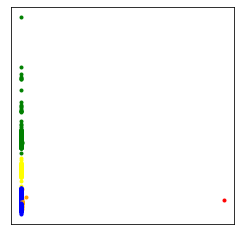

In [366]:
# binary=False
max_features = 100000
corpus = list_repo_description

cv_ = CountVectorizer(max_features=max_features, binary=False, lowercase=True, stop_words='english')
result = cv_.fit_transform(corpus)
print('words_num:',len(cv_.get_feature_names()))
#查看词频结果
#print(result.toarray())

#PCA降维
pca=PCA(n_components=2)
data=pca.fit_transform(result.toarray())

model = KMeans(n_clusters=6).fit(data)
draw(model, data)

In [367]:
# 语料库
max_features = 100000
corpus = list_repo_description
# 词向量的特征维度
cv_ = CountVectorizer(max_features=max_features, binary=True, lowercase=True, stop_words='english')
#计算词频
result = cv_.fit_transform(corpus)
#词汇数量
print('words_num:',len(cv_.get_feature_names()))
#输出词典
#print('feature_names:',cv_.get_feature_names())
#输出词汇
#print('vocabulary_',cv_.vocabulary_)
#查看词频结果
#print(result.toarray())

#PCA降维
pca=PCA(n_components=2)
data=pca.fit_transform(result.toarray())

words_num: 15127


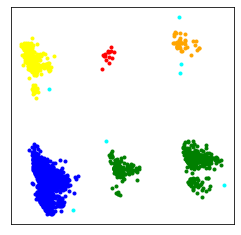

In [368]:
# 使用基于密度聚类的DBSCAN
model = DBSCAN(eps=0.1).fit(data)
draw(model, data)

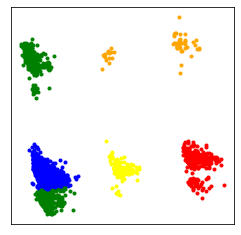

In [265]:
n_clusters = 6
model = KMeans(n_clusters=n_clusters).fit(data)
draw(model, data)

##### DBSCAN和KMeans的聚类效果

In [377]:
set_=set(model.labels_)
print(set_)
print(len(set_))

description0 = []
text_description0 = ""
k=0
for i in model.labels_:
    if i == 1:
        description0.append(list_repo_description[k])
        text_description0 += list_repo_description[k]
        text_description0 += " "
    k+=1

{0, 1, 2, 3, 4, 5, -1}
7


In [378]:
text = text_description0
#stopwords = set(['he', 'is'])
wc = WordCloud(
    #width=200,                  # 设置宽为400px
    #height=150,                 # 设置高为300px
    background_color='white',    # 设置背景颜色为白色
    #stopwords=stopwords,         # 设置禁用词，在生成的词云中不会出现set集合中的词
    #max_font_size=100,           # 设置最大的字体大小，所有词都不会超过100px
    #min_font_size=10,            # 设置最小的字体大小，所有词都不会超过10px
    #max_words=431,                # 设置最大的单词个数
    scale=2                     # 扩大两倍
)
wc.generate(text)
wc.to_file('img.jpg')

In [304]:
# 统计比例
cluster_ = []
for i in range(n_clusters):
    cluster_.append([])
k=0
for i in model.labels_:
    cluster_[i].append(list_repo_language[k])
    k+=1

In [343]:
def draw_pie(n):
    dict_={}
    for item in cluster_[n]:
        if item in dict_.keys():
            dict_[item]=dict_[item]+1
        else:
            dict_[item]=1
    dict_=sorted(dict_.items(),key=lambda x:x[1],reverse=True)
    lang = []
    frequency = []
    for i in range(15):
        lang.append(dict_[i][0])
        frequency.append(dict_[i][1])
    plt.pie(frequency, labels=lang)
    plt.title('cluster_' + str(n))
    plt.show()

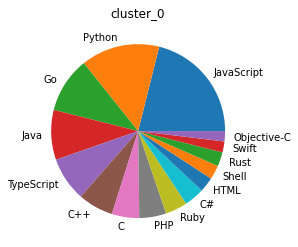

In [355]:
for n in range(1):
    draw_pie(n)